In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

Using device: cuda


100%|██████████| 170M/170M [00:08<00:00, 20.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/100] - Loss: 1.4924 - Train Acc: 44.66% - Val Acc: 54.82% - Time: 26.37s
Best model saved with Val Acc: 54.82%
Epoch [2/100] - Loss: 1.0047 - Train Acc: 64.15% - Val Acc: 62.69% - Time: 23.19s
Best model saved with Val Acc: 62.69%
Epoch [3/100] - Loss: 0.7907 - Train Acc: 72.34% - Val Acc: 69.81% - Time: 22.67s
Best model saved with Val Acc: 69.81%
Epoch [4/100] - Loss: 0.6600 - Train Acc: 77.26% - Val Acc: 73.68% - Time: 22.18s
Best model saved with Val Acc: 73.68%
Epoch [5/100] - Loss: 0.5624 - Train Acc: 80.57% - Val Acc: 75.44% - Time: 22.36s
Best model saved with Val Acc: 75.44%
Epoch [6/100] - Loss: 0.4768 - Train Acc: 83.56% - Val Acc: 76.61% - Time: 22.12s
Best model saved with Val Acc: 76.61%
Epoch [7/100] - Loss: 0.4106 - Train Acc: 85.88% - Val Acc: 77.86% - Time: 23.05s
Best model saved with Val Acc: 77.86%
Epoch [8/100] - Loss: 0.3476 - Train Acc: 87.98% - Val Acc: 77.48% - Ti

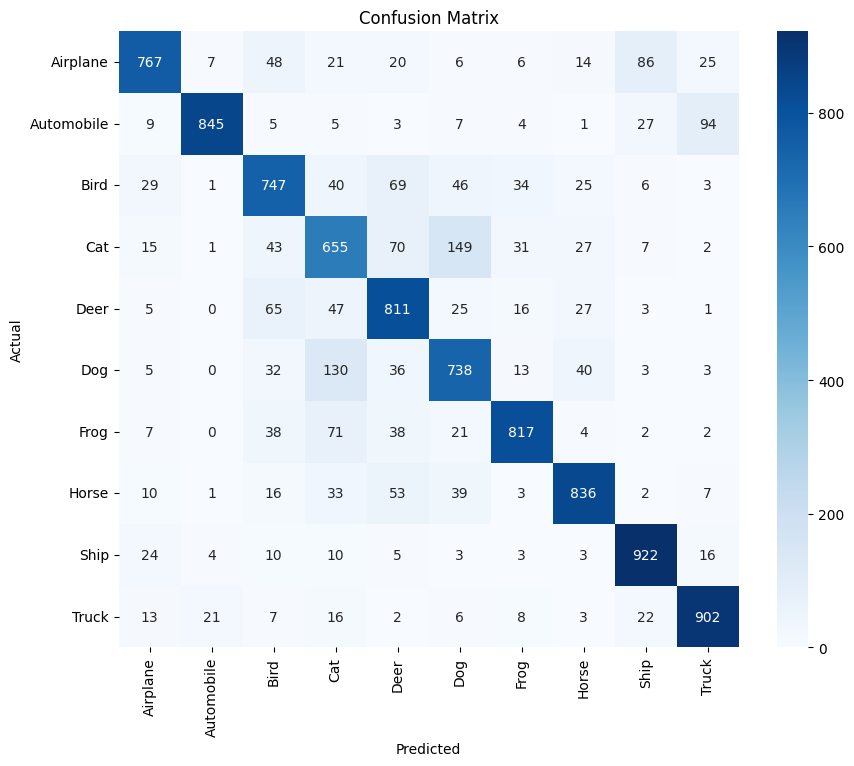

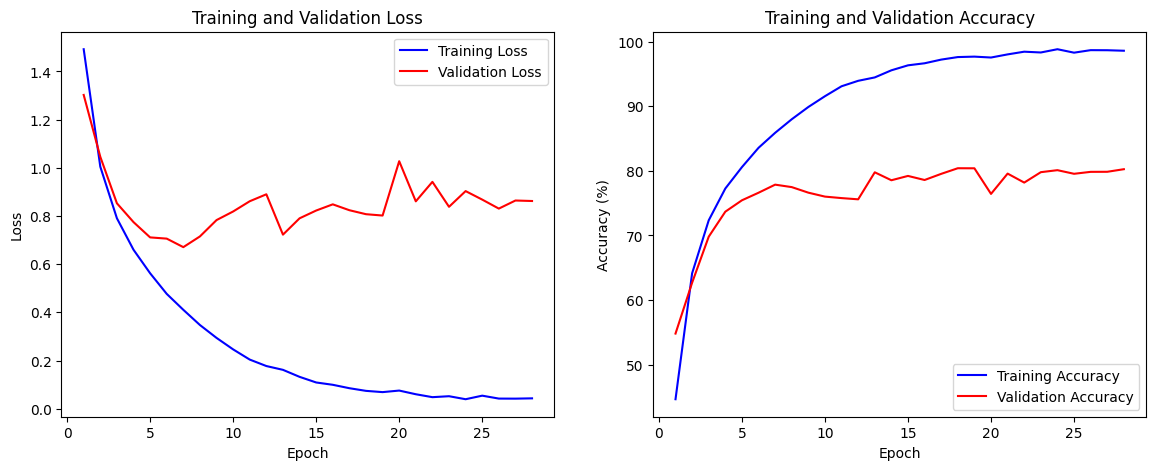

In [ ]:


# ----------------------------
# Residual Block Definition
# ----------------------------
class ResidualBlock(nn.Module):
    """
    A standard residual block with two convolutional layers and a skip connection.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)
        return out

# ----------------------------
# Global Feature Extractor
# ----------------------------
class GlobalFeatureExtractor(nn.Module):
    """
    Extracts global features from the input image with residual connections.
    """
    def __init__(self, in_channels, out_channels):
        super(GlobalFeatureExtractor, self).__init__()
        self.layer1 = ResidualBlock(in_channels, out_channels, stride=1)
        self.layer2 = ResidualBlock(out_channels, out_channels * 2, stride=2)
        self.pool = nn.AdaptiveAvgPool2d((1,1))

    def forward(self, x):
        x = self.layer1(x)  # [B, out_channels, H, W]
        x = self.layer2(x)  # [B, out_channels*2, H/2, W/2]
        x = self.pool(x)     # [B, out_channels*2, 1, 1]
        x = x.view(x.size(0), -1)  # [B, out_channels*2]
        return x

# ----------------------------
# Local Feature Extractor
# ----------------------------
class LocalFeatureExtractor(nn.Module):
    """
    Extracts local features from the input image with residual connections.
    """
    def __init__(self, in_channels, out_channels):
        super(LocalFeatureExtractor, self).__init__()
        self.layer1 = ResidualBlock(in_channels, out_channels, stride=1)
        self.layer2 = ResidualBlock(out_channels, out_channels * 2, stride=2)
        self.pool = nn.AdaptiveAvgPool2d((2,2))  # Retains some spatial information

    def forward(self, x):
        x = self.layer1(x)  # [B, out_channels, H, W]
        x = self.layer2(x)  # [B, out_channels*2, H/2, W/2]
        x = self.pool(x)     # [B, out_channels*2, 2, 2]
        return x

# ----------------------------
# Adaptive Attention Module
# ----------------------------
class AdaptiveAttentionModule(nn.Module):
    """
    Adaptive Attention Module that weights global and local features.
    """
    def __init__(self, global_dim, local_dim):
        super(AdaptiveAttentionModule, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(global_dim + local_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2),  # Outputs weights for global and local features
            nn.Softmax(dim=1)
        )

    def forward(self, global_feat, local_feat):
        # global_feat: [B, global_dim]
        # local_feat: [B, local_dim, H, W]
        local_feat_mean = torch.mean(local_feat, dim=[2,3])  # [B, local_dim]
        combined = torch.cat((global_feat, local_feat_mean), dim=1)  # [B, global_dim + local_dim]
        weights = self.attention(combined)  # [B, 2]
        global_weight = weights[:,0].unsqueeze(1)  # [B, 1]
        local_weight = weights[:,1].unsqueeze(1)   # [B, 1]
        return global_weight, local_weight  # Each [B, 1]

# ----------------------------
# Dynamic Holistic Perception Network
# ----------------------------
class DynamicHolisticPerceptionNetwork(nn.Module):
    """
    Dynamic Holistic Perception Network combining global and local features with residual connections.
    """
    def __init__(self, num_classes=10):
        super(DynamicHolisticPerceptionNetwork, self).__init__()
        # Initial Convolutional Layers
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # [B, 64, 32, 32] for CIFAR-10
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # [B, 64, 16, 16]
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # [B, 64, 16, 16]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)   # [B, 64, 8, 8]
        )

        # Feature Extractors with Residual Blocks
        self.global_extractor = GlobalFeatureExtractor(in_channels=64, out_channels=128)  # Output: [B, 256]
        self.local_extractor = LocalFeatureExtractor(in_channels=64, out_channels=128)    # Output: [B, 256, 2, 2]

        # Adaptive Attention Module
        self.adaptive_attention = AdaptiveAttentionModule(global_dim=256, local_dim=256)

        # Fusion and Classification Layers
        self.fusion_fc = nn.Sequential(
            nn.Linear(256 + 256, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.initial_conv(x)  # [B, 64, 8, 8]
        global_feat = self.global_extractor(x)  # [B, 256]
        local_feat = self.local_extractor(x)    # [B, 256, 2, 2]
        global_weight, local_weight = self.adaptive_attention(global_feat, local_feat)  # Each [B,1]

        # Weight the features
        global_feat_weighted = global_feat * global_weight  # [B, 256]
        local_feat_pooled = F.adaptive_avg_pool2d(local_feat, (1,1)).view(local_feat.size(0), -1)  # [B, 256]
        local_feat_weighted = local_feat_pooled * local_weight  # [B, 256]

        # Concatenate weighted features
        fused_feat = torch.cat((global_feat_weighted, local_feat_weighted), dim=1)  # [B, 512]

        # Classification
        out = self.fusion_fc(fused_feat)  # [B, num_classes]
        return out

# ----------------------------
# Evaluation Function
# ----------------------------
def evaluate_model(model, dataloader, device):
    """
    Evaluates the model on the given dataloader.
    Returns accuracy and confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)  # [B, num_classes]
            _, preds = torch.max(outputs, 1)  # [B]
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds) * 100
    cm = confusion_matrix(all_labels, all_preds)
    return acc, cm

# ----------------------------
# Visualization Functions
# ----------------------------
def plot_metrics(train_losses, val_accuracies, val_losses, train_accuracies):
    """
    Plots training and validation loss and accuracy over epochs.
    """
    epochs = range(1, len(train_losses)+1)

    plt.figure(figsize=(14,5))

    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

def plot_confusion_matrix(cm, classes):
    """
    Plots the confusion matrix.
    """
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# ----------------------------
# Main Training and Evaluation Pipeline
# ----------------------------
def main():
    # ----------------------------
    # Device Configuration
    # ----------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # ----------------------------
    # Hyperparameters
    # ----------------------------
    num_epochs = 100  # Increased epochs for better convergence
    batch_size = 128
    learning_rate = 0.01
    num_classes = 10  # For CIFAR-10
    patience = 10  # For early stopping

    # ----------------------------
    # Data Transformations
    # ----------------------------
    # Removed all data augmentation transforms as per user request
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

    # ----------------------------
    # Load Datasets
    # ----------------------------
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=0)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                             shuffle=False, num_workers=0)

    # ----------------------------
    # Initialize Model, Loss, Optimizer, Scheduler
    # ----------------------------
    model = DynamicHolisticPerceptionNetwork(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=0.1)

    # ----------------------------
    # Initialize Tracking Variables
    # ----------------------------
    best_val_acc = 0.0
    trigger_times = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # ----------------------------
    # Class Names for CIFAR-10
    # ----------------------------
    classes = ['Airplane','Automobile','Bird','Cat','Deer',
               'Dog','Frog','Horse','Ship','Truck']

    # ----------------------------
    # Training Loop with Early Stopping and Refinement
    # ----------------------------
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)  # [B, num_classes]
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        elapsed_time = time.time() - start_time

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        val_epoch_loss = val_running_loss / val_total
        val_epoch_acc = 100. * val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)

        # Scheduler step
        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Loss: {epoch_loss:.4f} - "
              f"Train Acc: {epoch_acc:.2f}% - "
              f"Val Acc: {val_epoch_acc:.2f}% - "
              f"Time: {elapsed_time:.2f}s")

        # Early Stopping and Saving Best Model
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            trigger_times = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Best model saved with Val Acc: {best_val_acc:.2f}%")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping triggered!")
                break

    # ----------------------------
    # Final Evaluation
    # ----------------------------
    print("\nTraining Completed!")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

    # Load the best model with security consideration
    torch_version = torch.__version__
    print(f"PyTorch Version: {torch_version}")

    try:
        state_dict = torch.load('best_model.pth', weights_only=True)
    except TypeError:
        state_dict = torch.load('best_model.pth')
        print("weights_only parameter not supported in this PyTorch version. "
              "Consider upgrading PyTorch for enhanced security.")

    model.load_state_dict(state_dict)

    final_acc, final_cm = evaluate_model(model, testloader, device)
    print(f"\nFinal Test Accuracy: {final_acc:.2f}%")
    plot_confusion_matrix(final_cm, classes)

    # ----------------------------
    # Plot Training and Validation Metrics
    # ----------------------------
    plot_metrics(train_losses, val_accuracies, val_losses, train_accuracies)

if __name__ == '__main__':
    main()


Streaming output truncated to the last 5000 lines.
Forward Pass - Fused Feature Shape: torch.Size([128, 128])
Forward Pass - Global Feature Shape: torch.Size([128, 64])
Forward Pass - Local Feature Shape: torch.Size([128, 64, 2, 2])
Combined Feature Shape (for attention): torch.Size([128, 128])
Query Shape: torch.Size([128, 1, 64])
Key Shape: torch.Size([128, 1, 64])
Value Shape: torch.Size([128, 1, 64])
Attention Output Shape: torch.Size([128, 64])
Weights Shape: torch.Size([128, 2])
Global Weight Shape: torch.Size([128, 1])
Local Weight Shape: torch.Size([128, 1])
Forward Pass - Global Feature Weighted Shape: torch.Size([128, 64])
Forward Pass - Local Feature Weighted Shape: torch.Size([128, 64])
Forward Pass - Fused Feature Shape: torch.Size([128, 128])
Forward Pass - Global Feature Shape: torch.Size([128, 64])
Forward Pass - Local Feature Shape: torch.Size([128, 64, 2, 2])
Combined Feature Shape (for attention): torch.Size([128, 128])
Query Shape: torch.Size([128, 1, 64])
Key Shape

<ipython-input-11-a84933214e3d>:434: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('best_model.pth', map_location=device)


Forward Pass - Global Feature Shape: torch.Size([100, 64])
Forward Pass - Local Feature Shape: torch.Size([100, 64, 2, 2])
Combined Feature Shape (for attention): torch.Size([100, 128])
Query Shape: torch.Size([100, 1, 64])
Key Shape: torch.Size([100, 1, 64])
Value Shape: torch.Size([100, 1, 64])
Attention Output Shape: torch.Size([100, 64])
Weights Shape: torch.Size([100, 2])
Global Weight Shape: torch.Size([100, 1])
Local Weight Shape: torch.Size([100, 1])
Forward Pass - Global Feature Weighted Shape: torch.Size([100, 64])
Forward Pass - Local Feature Weighted Shape: torch.Size([100, 64])
Forward Pass - Fused Feature Shape: torch.Size([100, 128])
Forward Pass - Global Feature Shape: torch.Size([100, 64])
Forward Pass - Local Feature Shape: torch.Size([100, 64, 2, 2])
Combined Feature Shape (for attention): torch.Size([100, 128])
Query Shape: torch.Size([100, 1, 64])
Key Shape: torch.Size([100, 1, 64])
Value Shape: torch.Size([100, 1, 64])
Attention Output Shape: torch.Size([100, 64])

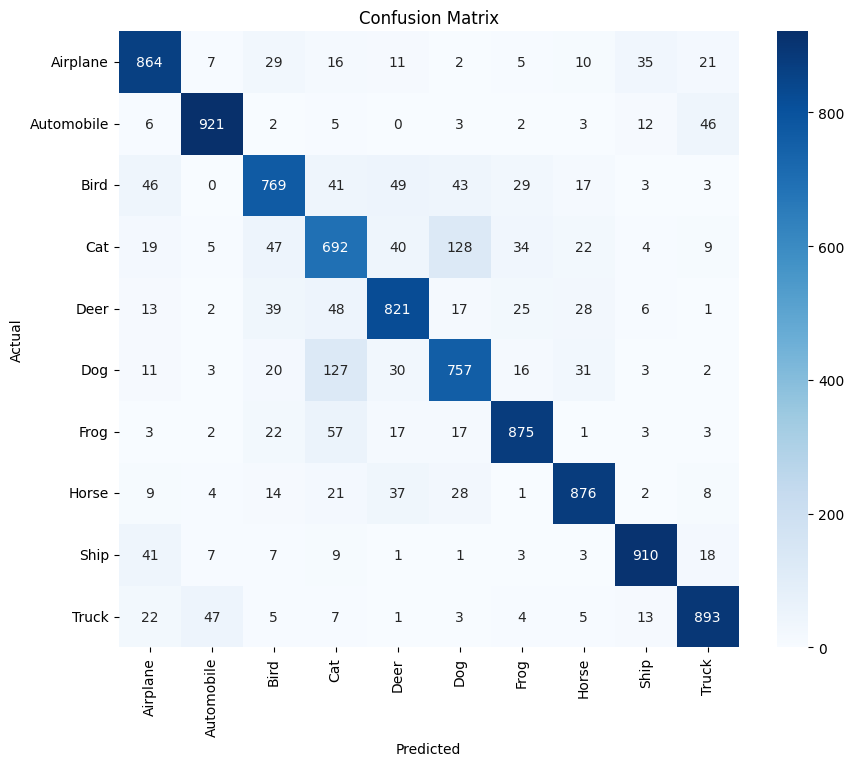

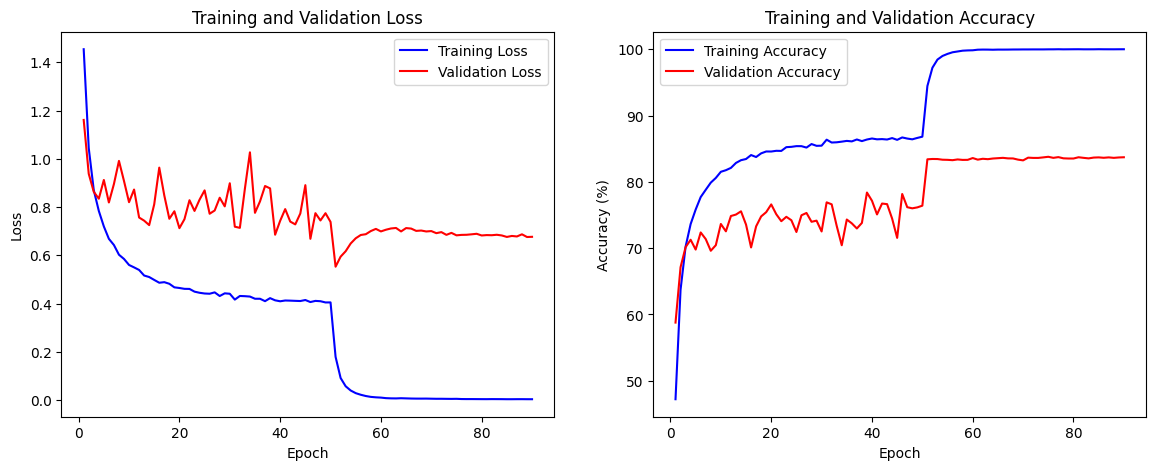

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# ----------------------------
# Residual Block Definition
# ----------------------------
class ResidualBlock(nn.Module):
    """
    A standard residual block with two convolutional layers and a skip connection.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride !=1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)
        out = self.relu(out)
        return out

# ----------------------------
# Global Feature Extractor
# ----------------------------
class GlobalFeatureExtractor(nn.Module):
    """
    Extracts global features from the input image with residual connections.
    """
    def __init__(self, in_channels, out_channels, num_blocks=3):
        super(GlobalFeatureExtractor, self).__init__()
        layers = []
        for i in range(num_blocks):
            stride = 1 if i ==0 else 2
            layers.append(ResidualBlock(in_channels if i ==0 else out_channels, out_channels, stride))
            in_channels = out_channels  # Update in_channels for next block
        self.layer = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool2d((1,1))

    def forward(self, x):
        x = self.layer(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return x  # [B, out_channels]

# ----------------------------
# Local Feature Extractor
# ----------------------------
class LocalFeatureExtractor(nn.Module):
    """
    Extracts local features from the input image with residual connections.
    """
    def __init__(self, in_channels, out_channels, num_blocks=3):
        super(LocalFeatureExtractor, self).__init__()
        layers = []
        for i in range(num_blocks):
            stride = 1 if i ==0 else 2
            layers.append(ResidualBlock(in_channels if i ==0 else out_channels, out_channels, stride))
            in_channels = out_channels  # Update in_channels for next block
        self.layer = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool2d((2,2))  # Retains some spatial information

    def forward(self, x):
        x = self.layer(x)
        x = self.pool(x)
        return x  # [B, out_channels, 2, 2]

# ----------------------------
# Enhanced Adaptive Attention Module
# ----------------------------
class EnhancedAdaptiveAttentionModule(nn.Module):
    """
    Enhanced Adaptive Attention Module with Multi-Head Attention.
    """
    def __init__(self, global_dim, local_dim, num_heads=4):
        super(EnhancedAdaptiveAttentionModule, self).__init__()
        self.query = nn.Linear(global_dim + local_dim, global_dim)
        self.key = nn.Linear(global_dim + local_dim, global_dim)
        self.value = nn.Linear(global_dim + local_dim, global_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=global_dim, num_heads=num_heads, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(global_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, global_feat, local_feat):
        # global_feat: [B, global_dim]
        # local_feat: [B, local_dim, H, W]
        local_feat_mean = torch.mean(local_feat, dim=[2,3])  # [B, local_dim]
        combined = torch.cat((global_feat, local_feat_mean), dim=1)  # [B, global_dim + local_dim]
        print(f"Combined Feature Shape (for attention): {combined.shape}")  # Should be [B, 512]

        query = self.query(combined).unsqueeze(1)  # [B,1,512]
        key = self.key(combined).unsqueeze(1)      # [B,1,512]
        value = self.value(combined).unsqueeze(1)  # [B,1,512]
        print(f"Query Shape: {query.shape}")  # [B,1,512]
        print(f"Key Shape: {key.shape}")      # [B,1,512]
        print(f"Value Shape: {value.shape}")  # [B,1,512]

        attn_output, _ = self.multihead_attn(query, key, value)  # [B,1,512]
        attn_output = attn_output.squeeze(1)  # [B,512]
        print(f"Attention Output Shape: {attn_output.shape}")  # [B,512]

        weights = self.fc(attn_output)  # [B,2]
        print(f"Weights Shape: {weights.shape}")  # [B,2]

        global_weight = weights[:,0].unsqueeze(1)  # [B,1]
        local_weight = weights[:,1].unsqueeze(1)   # [B,1]
        print(f"Global Weight Shape: {global_weight.shape}")  # [B,1]
        print(f"Local Weight Shape: {local_weight.shape}")    # [B,1]

        return global_weight, local_weight  # Each [B,1]

# ----------------------------
# Dynamic Holistic Perception Network
# ----------------------------
class DynamicHolisticPerceptionNetwork(nn.Module):
    """
    Dynamic Holistic Perception Network combining global and local features with residual connections.
    """
    def __init__(self, num_classes=10):
        super(DynamicHolisticPerceptionNetwork, self).__init__()
        # Initial Convolutional Layers
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # [B,64,32,32]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # [B,64,16,16]
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # [B,64,16,16]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)   # [B,64,8,8]
        )

        # Feature Extractors with Residual Blocks
        self.global_extractor = GlobalFeatureExtractor(in_channels=64, out_channels=64, num_blocks=3)  # Output: [B,64]
        self.local_extractor = LocalFeatureExtractor(in_channels=64, out_channels=64, num_blocks=3)    # Output: [B,64,2,2]

        # Enhanced Adaptive Attention Module
        self.adaptive_attention = EnhancedAdaptiveAttentionModule(global_dim=64, local_dim=64, num_heads=4)

        # Fusion and Classification Layers
        self.fusion_fc = nn.Sequential(
            nn.Linear(64 + 64, 128),  # [B,128]
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.initial_conv(x)  # [B,64,8,8]
        global_feat = self.global_extractor(x)  # [B,64]
        local_feat = self.local_extractor(x)    # [B,64,2,2]
        print(f"Forward Pass - Global Feature Shape: {global_feat.shape}")  # Should be [B,64]
        print(f"Forward Pass - Local Feature Shape: {local_feat.shape}")    # Should be [B,64,2,2]

        global_weight, local_weight = self.adaptive_attention(global_feat, local_feat)  # Each [B,1]

        # Weight the features
        global_feat_weighted = global_feat * global_weight  # [B,64]
        local_feat_pooled = F.adaptive_avg_pool2d(local_feat, (1,1)).view(local_feat.size(0), -1)  # [B,64]
        local_feat_weighted = local_feat_pooled * local_weight  # [B,64]
        print(f"Forward Pass - Global Feature Weighted Shape: {global_feat_weighted.shape}")  # [B,64]
        print(f"Forward Pass - Local Feature Weighted Shape: {local_feat_weighted.shape}")    # [B,64]

        # Concatenate weighted features
        fused_feat = torch.cat((global_feat_weighted, local_feat_weighted), dim=1)  # [B,128]
        print(f"Forward Pass - Fused Feature Shape: {fused_feat.shape}")  # [B,128]

        # Classification
        out = self.fusion_fc(fused_feat)  # [B, num_classes]
        return out

# ----------------------------
# Evaluation Function
# ----------------------------
def evaluate_model(model, dataloader, device):
    """
    Evaluates the model on the given dataloader.
    Returns accuracy, confusion matrix, and average loss.
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_losses = []
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)  # [B, num_classes]
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)  # [B]
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_losses.append(loss.item() * inputs.size(0))
    acc = accuracy_score(all_labels, all_preds) * 100
    cm = confusion_matrix(all_labels, all_preds)
    avg_loss = sum(all_losses) / len(dataloader.dataset)
    return acc, cm, avg_loss

# ----------------------------
# Visualization Functions
# ----------------------------
def plot_metrics(train_losses, val_accuracies, val_losses, train_accuracies):
    """
    Plots training and validation loss and accuracy over epochs.
    """
    epochs = range(1, len(train_losses)+1)

    plt.figure(figsize=(14,5))

    # Plot Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

def plot_confusion_matrix(cm, classes):
    """
    Plots the confusion matrix.
    """
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# ----------------------------
# Main Training and Evaluation Pipeline
# ----------------------------
def main():
    # ----------------------------
    # Device Configuration
    # ----------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # ----------------------------
    # Hyperparameters
    # ----------------------------
    num_epochs = 100  # Increased epochs for better convergence
    batch_size = 128
    learning_rate = 0.1
    num_classes = 10  # For CIFAR-10
    patience = 15  # For early stopping

    # ----------------------------
    # Data Transformations
    # ----------------------------
    # Removed all data augmentation transforms as per user request
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

    # ----------------------------
    # Load Datasets
    # ----------------------------
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                             shuffle=False, num_workers=2)

    # ----------------------------
    # Initialize Model, Loss, Optimizer, Scheduler
    # ----------------------------
    model = DynamicHolisticPerceptionNetwork(num_classes=num_classes).to(device)
    print("Model initialized.")
    print(model)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

    # ----------------------------
    # Initialize Tracking Variables
    # ----------------------------
    best_val_acc = 0.0
    trigger_times = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # ----------------------------
    # Class Names for CIFAR-10
    # ----------------------------
    classes = ['Airplane','Automobile','Bird','Cat','Deer',
               'Dog','Frog','Horse','Ship','Truck']

    # ----------------------------
    # Delete existing best_model.pth to avoid loading incompatible weights
    # ----------------------------
    if os.path.exists('best_model.pth'):
        os.remove('best_model.pth')
        print("Existing 'best_model.pth' removed.")

    # ----------------------------
    # Training Loop with Early Stopping and Refinement
    # ----------------------------
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)  # [B, num_classes]
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        elapsed_time = time.time() - start_time

        # Validation
        val_acc, val_cm, val_loss = evaluate_model(model, testloader, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Scheduler step
        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Loss: {epoch_loss:.4f} - "
              f"Train Acc: {epoch_acc:.2f}% - "
              f"Val Acc: {val_acc:.2f}% - "
              f"Val Loss: {val_loss:.4f} - "
              f"Time: {elapsed_time:.2f}s")

        # Early Stopping and Saving Best Model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            trigger_times = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Best model saved with Val Acc: {best_val_acc:.2f}%")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping triggered!")
                break

    # ----------------------------
    # Final Evaluation
    # ----------------------------
    print("\nTraining Completed!")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

    # Load the best model with security consideration
    torch_version = torch.__version__
    print(f"PyTorch Version: {torch_version}")

    # Load best_model.pth
    if os.path.exists('best_model.pth'):
        try:
            # Load state_dict directly
            state_dict = torch.load('best_model.pth', map_location=device)
            model.load_state_dict(state_dict)
            print("Best model loaded successfully.")
        except Exception as e:
            print(f"Error loading best_model.pth: {e}")
            print("Please ensure that the model architecture matches exactly when saving and loading.")
    else:
        print("No best model found to load.")

    # Final evaluation
    final_acc, final_cm, final_loss = evaluate_model(model, testloader, device)
    print(f"\nFinal Test Accuracy: {final_acc:.2f}%")
    plot_confusion_matrix(final_cm, classes)

    # ----------------------------
    # Plot Training and Validation Metrics
    # ----------------------------
    plot_metrics(train_losses, val_accuracies, val_losses, train_accuracies)

if __name__ == '__main__':
    main()
